# Some intuition about stochastic calculus

I started this notebook on stochastic calculus because I couldn't even answer the first question on stochastic processes in Joshi's book [(Quant Job Interview Questions and Answers)](https://www.amazon.co.uk/Quant-Interview-Questions-Answers-Second/dp/0987122827). This notebook is about intuition; it doesn't really have rigorous maths.

The biggest intuition I gathered about stochastic processes is that even though we work with stochastic _differential_ equations (SDEs), really it's all about stochastic _integration_. The intuition built in this notebook is only a foundation, hopefully enough to study for harder questions about stochastic processes. I built my intuition using a combination of chapters from books, videos and PDFs. I wrote code to confirm my intuition, after which I included some typical derivations you might get asked in quant finance interviews (geometric Brownian motion, Black-Scholes). After the derivation I put some closing thoughts and appendices for further reading.

While making this notebook I used the following resources. As I go through the notebook I'll say what I used each resource for.

- [Video on the intuition in stochastic integration by Professor Hendrik Hakenes](https://www.youtube.com/watch?v=_4zyAFpJ_Z4)
- Chapter 10 of Introduction to Probability Models by Sheldon Ross
- Chapter 3 of Stochastic Calculus for Finance II by Steve Shreve
- Introduction to Stochastic Integration by Hui-Hsiung Kuo
- Quadratic variation of Brownian motion ([notes by Professor Whitt](http://www.columbia.edu/~ww2040/4701Sum07/lec0813.pdf), [video by Quantpie](https://www.youtube.com/watch?v=AptlhWEgOto))
- [Playlist by MathsPartner](https://www.youtube.com/playlist?list=PLg5nrpKdkk2BZoZYAg2d6Ma3HZ5p9h35i)
- [Derivation of geometric Brownian motion](https://www.quantstart.com/articles/Geometric-Brownian-Motion)
- [Derivation of Black-Scholes by Perfiliev](https://www.youtube.com/watch?v=NHvQ5CSSgw0)


In [39]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np

## Deterministic numerical integration (using an ordinary variable)

This part was inspired by the start of [this video by Professor Hendrik Hakenes about stochastic integration](https://www.youtube.com/watch?v=_4zyAFpJ_Z4). It goes through "normal" integration which we are (hopefully) already familiar with. The idea is to code up an example of numerical integration and see how we can extend it to stochastic integration.  

We start our example by considering the differential equation

$$\frac{df(x)}{dx} = g(x)$$

We can approximate the derivative at a point $x_0$ as

$$\frac{f(x_0 + \Delta x) - f(x_0)}{\Delta x} = g(x_0)$$

If $\Delta x$ is really small.

Now, if we know $f(x_0)$ and we have an expression for the gradient function $g(x)$ so that we can compute $g(x_0)$, then we can rearrange and compute $f(x_0 + \Delta x)$

$$f(x_0 + \Delta x) = f(x_0) + \Delta x \cdot g(x_0)$$

Let $x_1 = x_0 + \Delta x$. We can again approximate the derivative at the point $x_1$ and compute $f(x_1 + \Delta x) $ because we computed $f(x_1)$ previously

$$\frac{f(x_1 + \Delta x) - f(x_1)}{\Delta x} = g(x_1) \implies f(x_1 + \Delta x) = f(x_1) + \Delta x \cdot g(x_1)$$

Now let $x_2 = x_1 + \Delta x$. We can approximate the derivative at the point $x_2$ and compute $f(x_2 + \Delta x)$

$$\frac{f(x_2 + \Delta x) - f(x_2)}{\Delta x} = g(x_2) \implies f(x_2 + \Delta x) = f(x_2) + \Delta x \cdot g(x_2)$$

In general

$$f(x_i + \Delta x) = f(x_i) + \Delta x \cdot g(x_i)$$

Where $x_i = x_0 + i \Delta x$. With this notation, $x_i + \Delta x = x_{i+1}$ so we can rewrite the above as a recursive formula

$$f(x_{i+1}) = f(x_i) + \Delta x \cdot g(x_i) \implies f(x_i) = f(x_{i-1}) + \Delta x \cdot g(x_{i-1}) \label{eq:det_integral} \tag{1}$$

We can repeatedly apply this formula to compute $f(x_1), f(x_2), \ldots, f(x_i), \ldots, f(x_n)$ and therefore numerically solve for $f(x)$ over the interval $[x_{start}, x_{end}]$ by partitioning the interval into $n$ subintervals $[x_{i-1}, x_i]$, where $n = \frac{x_{end} - x_{start}}{\Delta x}$ and $x_{start} = x_0 < x_1 < \cdots < x_i < \cdots < x_n = x_{end}$.

## Implementing deterministic numerical integration

We do deterministic numerical integration considering a gradient function $g(x) = \cos{x}$. The solution from numerical integration should be close to the analytic solution, which we know is $\sin{x}$.

In [40]:
# recursive integration formula
def integrate_numerical(
    previous_value,
    dx,
    gradient_function,
    previous_x
):
    return previous_value + dx * gradient_function(previous_x)

In [41]:
# computing x_0, x_1, x_2, ...
def partition_interval(
    x_start,
    x_end,
    dx
):
    N = int( (x_end - x_start) / dx )
    
    return [ x_start + dx * i for i in range(N+1) ]

In [42]:
# repeatedly applying the recursive integration formula to solve for f(x)
def compute_numerical_solution(
    x,
    dx,
    gradient_function,
    init_value
):
    previous_x     = x[0]       # x_{i-1};      to start, n = 1 so previous_x = x0
    previous_value = init_value # f( x_{i-1} ); to start, n = 1 so previous_value = so f(x0)
    
    numerical_solution = [previous_value]
    
    # already have info at i = 0, so start at i = 1 i.e. x[1:]
    for x_ in x[1:]:
        numerical_solution.append(
            integrate_numerical(
                previous_value=previous_value,
                dx=dx,
                gradient_function=gradient_function,
                previous_x=previous_x
            )
        )
        
        # current x_ becomes previous_x for i + 1
        previous_x = x_
        
        # current value becomes previous_value for i + 1
        previous_value = numerical_solution[-1]
        
    return numerical_solution

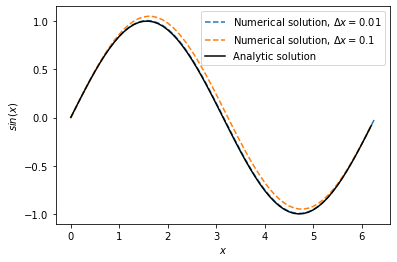

In [26]:
# solving for f(x) over the interval [0,5] using different dx's
x_start           = 0
x_end             = 2 * math.pi
dxs               = [0.01, 0.1]
gradient_function = math.cos
init_value        = 0

fig, ax = plt.subplots()

for dx in dxs:
    x = partition_interval(
        x_start=x_start,
        x_end=x_end,
        dx=dx
    )
    
    numerical_solution = compute_numerical_solution(
        x=x,
        dx=dx,
        gradient_function=gradient_function,
        init_value=init_value
    )
    
    ax.plot(
        x,
        numerical_solution,
        linestyle="--",
        label="Numerical solution, $\Delta x = %s$" % dx
    )

ax.plot(
    x,
    [math.sin(x_) for x_ in x],
    color="black",
    label="Analytic solution"
)

ax.legend()
ax.set_ylabel("$sin(x)$")
ax.set_xlabel("$x$")

plt.show()

Indeed, the numerical solution is very similar to the analytic solution $\sin{x}$; also, the smaller the $\Delta x$ the closer it is. For $\Delta x = 0.01$ there is no visible difference between the numerical and analytic solutions.

## Stochastic numerical integration (using a random variable)

We now attempt to make the deterministic integration above into something stochastic.

Consider the recursive numerical integration formula: we can recursively expand the expressions for $f(x_{n-1}), f(x_{n-2}), f(x_{n-3}), \ldots$ until we reach $f(x_0)$ to express the formula as a summation instead

$$\begin{align}
f(x_n) &= f(x_{n-1}) + \Delta x \cdot g(x_{n-1}) \\
f(x_n) &= f(x_{n-2}) + \Delta x \cdot g(x_{n-2}) + \Delta x \cdot g(x_{n-1}) \\
f(x_n) &= f(x_{n-3}) + \Delta x \cdot g(x_{n-3}) + \Delta x \cdot g(x_{n-2}) + \Delta x \cdot g(x_{n-1}) \\
\dots \\
f(x_n) &= f(x_0) + \Delta x \cdot g(x_0) + \Delta x \cdot g(x_1) + \dots + \Delta x \cdot g(x_i) + \dots + \Delta x \cdot g(x_{n-1}) \\
       &= f(x_0) + \sum_{i=0}^{n-1} \Delta x \cdot g(x_{i})
\end{align}$$

Where $g(x_i)$ are like pieces that we add to build up $f(x_n)$. These pieces are deterministic because we compute them using the gradient function $g(x)$.

Let's say we made the pieces stochastic instead of deterministic, that is, they took on random values instead of being computed from a deterministic function (inspired by the start of Chapter 10 of "Introduction to Probability Models" by Sheldon Ross)

$$\begin{align}
W(x_n) &= W(x_0) + \Delta x \cdot X_0 + \Delta x \cdot X_1 + \dots + \Delta x \cdot X_i + \dots + \Delta x \cdot X_{n-1} \\
       &= 0 + \sum_{i=0}^{n-1} \Delta x \cdot X_{i}
\end{align}$$

Where $X_i$ is a random variable and $W(x_0) = 0$. This formula can be expressed recursively as well

$$\begin{align}
W(x_1) &= \Delta x \cdot X_0 \\
\\
W(x_2) &= \Delta x \cdot X_0 + \Delta x \cdot X_1 \\
       &= X(x_1) + \Delta x \cdot X_1 \\
\\
W(x_3) &= \Delta x \cdot X_0 + \Delta x \cdot X_1 + \Delta x \cdot X_2 \\
       &= X(x_1) + \Delta x \cdot X_1  + \Delta x \cdot X_2 \\
       &= X(x_2) + \Delta x \cdot X_2
\end{align}$$

In general

$$W(x_i) = W(x_{i-1}) + \Delta x \cdot X_{i-1}$$

Where we take $W(x_0) = 0$.

Now let's do some "stochastic" numerical integration where $X_i$ has a 50/50 chance of being either 1 or -1.

In [43]:
# random variable with 50/50 chance of being 1 or -1
def coinflip():
    return 1 if random.random() < 0.5 else -1

In [44]:
# recursive stochastic integration formula
def integrate_numerical_stochastic(
    dx,
    previous_value
):
    return previous_value + dx * coinflip()

In [45]:
# repeatedly applying the recursive stochastic integration formula for given n
def compute_stochastic_numerical_solution(
    n,
    dx
):
    W = [0]
    
    for i in range(n):
        W.append(
            integrate_numerical_stochastic(
                dx=dx,
                previous_value=W[-1]
            )
        )
    
    return W

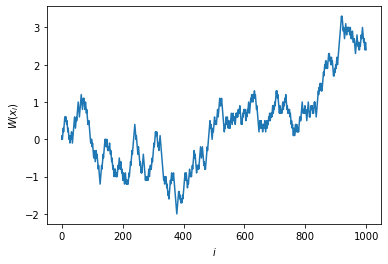

In [47]:
n  = 1000
dx = 0.1

fig, ax = plt.subplots()

stochastic_numerical_solution = compute_stochastic_numerical_solution(dx=dx, n=n)

ax.plot(stochastic_numerical_solution)
ax.set_xlabel("$i$")
ax.set_ylabel("$W(x_i)$")

plt.show()

## Mathematical analysis of the random variable

Our code computes $W(x_i)$ which already gives a line that looks like a stock price. Let's move on from our code and do some mathematical analysis on the function $W(x_i)$.

The function $W(x_i)$ can be thought of as a "process" because it evolves step by step via each (random) increment of $\Delta x \cdot X_i$.

Let's consider a process $W(t_i)$ (we changed the variable $x$ to $t$ for time because this feels closer to what happens in finance)

$$\begin{align}
W(t_n) &= W(t_0) + \Delta x \cdot X_0 + \Delta x \cdot X_1 + \dots + \Delta x \cdot X_i + \dots + \Delta x \cdot X_{n-2} + \Delta x \cdot X_{n-1} \\
       &= 0 + \sum_{i=0}^{n-1} \Delta x \cdot X_i
\end{align}$$

Where $n = \frac{t_n}{\Delta t}$ and $X_i$ is a discrete random variable with probability distribution

$$P(X_i = 1) = P(X_i = -1) = 0.5$$

As $X_i$ has 2 outcomes ($-1$ and $1$), the expected value $E[\Delta x \cdot X_i]$ can be computed as

$$\begin{align}
E[\Delta x \cdot X_i] &= \sum_{i = 1}^M \Delta x \cdot X_i P(X_i = 1 \, or \, X_i = -1) \\
                      &= \Delta x \cdot (1) \cdot 0.5 + \Delta x \cdot (-1) \cdot 0.5 \\
                      &= 0
\end{align}$$

Abusing notation, but taking $P(X_i)$ to be the probability distribution of $X_i$, its variance is computed as

$$ V[\Delta x \cdot X_i] = \sum_{i = 1}^M (\Delta x \cdot X_i - E[X_i])^2 P(X_i) $$

But $E[X_i] = 0$ so

$$\begin{align}
V[\Delta x \cdot X_i] &= \sum_{i = 1}^M (\Delta x \cdot X_i - 0)^2 P(X_i) \\
                      &= \sum_{i = 1}^M (\Delta x)^2 \cdot X_i^2 P(X_i) \\
                      &= (\Delta x)^2 \sum_{i = 1}^M X_i^2 P(X_i) \\
                      &= (\Delta x)^2 \big( (1)^2 \cdot 0.5 + (-1)^2 \cdot 0.5 \big)\\
                      &= (\Delta x)^2
\end{align}$$

Since $X_i$ is a random variable, $W(t_n)$ must also be a random variable because it's constructed from $X_i$ and anything constructed from random variables is itself a random variable.

Hence, we can compute the expected value:

$$E[X(t_n)] = E\Big[\sum_{i=0}^{n-1} \Delta x \cdot X_i \Big]$$

The expected value of a sum of random variables is the sum of the expected values of each random variable.

$$\begin{align}
E\Big[\sum_{i=0}^{n-1} \Delta x \cdot X_i \Big] &= \sum_{i=0}^{n-1} E[\Delta x \cdot X_i] \\
                                            &= \sum_{i=0}^{n-1} 0 \\
                                            &= 0
\end{align}$$

Similar arguments can be made for the variance:

$$\begin{align}
V[W(t_n)] &= V\Big[\sum_{i=0}^{n-1} \Delta x \cdot X_i \Big] \\
          &= \sum_{i=0}^{n-1} V[\Delta x \cdot X_i] \\
          &= \sum_{i=0}^{n-1} (\Delta x)^2 \\
          &= n \cdot (\Delta x)^2 \\
          &= \frac{t_n}{\Delta t} \cdot (\Delta x)^2
\end{align}$$

Something interesting happens if we set $\Delta x = \sigma \sqrt{\Delta t}$:

$$\begin{align}
V[W(t_n)] &= \frac{t_n}{\Delta t} \cdot \Delta x \\
          &= \frac{t_n}{\Delta t} \big( \sigma \sqrt{\Delta t} \big)^2 \\
          &= \frac{t_n}{\Delta t} \sigma^2 \Delta t \\
          &= \sigma^2 t_n
\end{align}$$

So for the special case where we make the "increment size" $\Delta x$ equal to $\sigma \sqrt{\Delta t}$, the expected value of $W(t_n)$ is 0 and its variance is $\sigma^2 t_n$. Also, $W(t_n)$ is known as a "random walk", a "Brownian motion" or a "Wiener process".

## Implementing the random variable

We now write code to compute $W(t_n)$ and do some computational analysis to verify the mathematical analysis on $E[W(t_n)]$ and $V[W(t_n)]$.

In [48]:
def compute_random_walk(
    dt,
    t,
    sigma
):
    nt = int(t / dt)
    
    dx = sigma * np.sqrt(dt)
    
    W = [0]
    
    for i in range(nt):
        W.append( W[i] + dx * coinflip() )
    
    return W

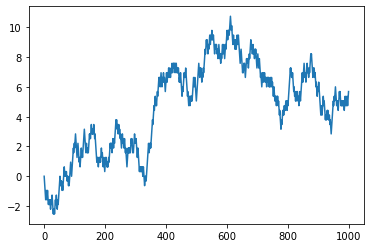

In [51]:
# computing a random walk to see if our code works
W = compute_random_walk(
    t=100,
    dt=0.1,
    sigma=1
)

fig, ax = plt.subplots()

plt.plot(W)

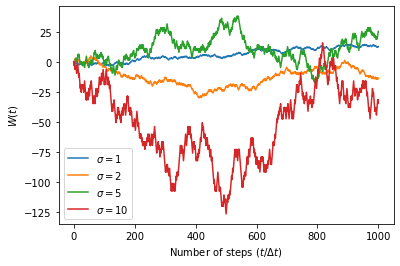

In [50]:
# computing random walks with various "jump sizes"
fig, ax = plt.subplots()

t  = 100
dt = 0.1

sigmas = [1, 2, 5, 10]

for sigma in sigmas:
    W = compute_random_walk(
        t=t,
        dt=dt,
        sigma=sigma
    )
    
    ax.plot(W, label="$\sigma = %s$" % sigma)
    ax.set_xlabel("Number of steps $(t / \Delta t)$")
    ax.set_ylabel("$W(t)$")
    ax.legend()

If we correctly compute random walks using different values of $\sigma$, we would expect the random walks computed using larger $\sigma$ to vary more in their paths. We see this in the plot above.

We also know from the mathematical analysis that variance follows the relationship

$$V[W(t)] = \sigma^2 t$$

For clarity, we make plots of this below.

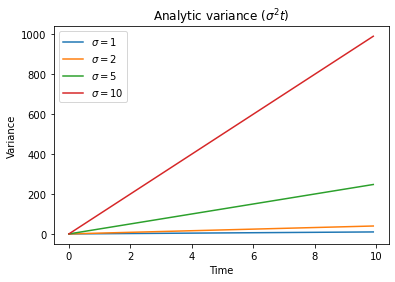

In [62]:
t  = 10
dt = 0.1

nt = int(t / dt)

sigmas = [1, 2, 5, 10]

# computing sigma against time for various sigmas using analytical expression
var_analytic = {sigma : [ sigma * sigma * dt * i for i in range(nt) ] for sigma in sigmas}

fig, ax = plt.subplots()

for sigma in sigmas:
    ax.plot(
        [ dt * i for i in range(nt) ],
        var_analytic[sigma],
        label="$\sigma = %s$" % sigma
    )
    
    ax.set_title("Analytic variance ($\sigma^2 t$)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Variance")
    ax.legend()

### Verification using computational analysis

In theory, if we compute many random walks and compute the expected value and variance over time, the computed values should closely follow the above lines.

First, we compute many random walks for a single $\sigma$.

In [35]:
def compute_many_random_walks(
    num_trials,
    t,
    dt,
    sigma
):
    return np.array( [ compute_random_walk( t=t, dt=dt, sigma=sigma ) for trial in range(num_trials) ] )

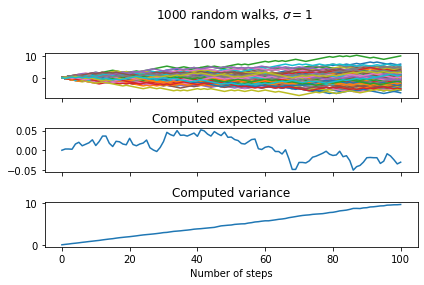

In [60]:
num_trials = 1_000

t  = 10
dt = 0.1

random_walks = compute_many_random_walks(
    num_trials=num_trials,
    t=t,
    dt=dt,
    sigma=sigmas[0]
)

mean_numerical = np.mean(random_walks, axis=0)
var_numerical  = np.var(random_walks,  axis=0)

fig, axs = plt.subplots(
    nrows=3,
    ncols=1,
    sharex=True
)

# only plot first 100 trials
for trial in range(100):
    axs[0].plot( random_walks[trial] )
    
fig.suptitle("%s random walks, $\sigma = %s$" % (num_trials, sigmas[0]), x=0.55)
axs[0].set_title("100 samples")
axs[1].plot(mean_numerical); axs[1].set_title("Computed expected value")
axs[2].plot(var_numerical);  axs[2].set_title("Computed variance")
axs[2].set_xlabel("Number of steps")
fig.tight_layout()

The top panel of the plot above shows a 100 of the many random walks we compute. They diverge over time.

The middle panel shows the expected value that we compute from the random walks over time. The computed expected value stays fairly close to zero as hoped (from mathematical analysis, $E[W(t)] = 0$).

The bottom panel shows the variance that we compute from the random walks over time. The computed variance grows linearly as hoped (from mathematical analysis, $V[W(t)] = \sigma^2 t$).

Ideally, we should include the computed variance and the analytic variance in the same plot, which is what we do below using different values of $\sigma$.

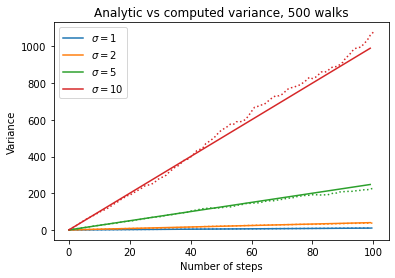

In [61]:
mean_numerical = {sigma : {} for sigma in sigmas}
var_numerical  = {sigma : {} for sigma in sigmas}

num_trials = 500

t  = 10
dt = 0.1

for sigma in sigmas:
    random_walks = compute_many_random_walks(
        num_trials=num_trials,
        t=t,
        dt=dt,
        sigma=sigma
    )
    
    mean_numerical[sigma] = np.mean(random_walks, axis=0)
    var_numerical[sigma]  = np.var(random_walks,  axis=0)

fig, ax = plt.subplots()

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for color, sigma in zip(colors, sigmas):
    ax.plot(
        var_analytic[sigma],
        label="$\sigma = %s$" % sigma,
        linestyle='-',
        color=color
    )
    
    ax.plot(
        var_numerical[sigma],
        linestyle=':',
        color=color
    )
    
    ax.set_title("Analytic vs computed variance, %s walks" % num_trials)
    ax.set_xlabel("Number of steps")
    ax.set_ylabel("Variance")
    ax.legend()

This time we only compute 500 random walks per value of $\sigma$, but even so we can see that computed values closely follow the analytic values.

## Problems with integrating an (S)DE containing a random variable

At the beginning of this discussion, we started by integrating using an ordinary (deterministic) variable, then we did integration using a random (stochastic) variable. What happens if we try to do integration using both an deterministic and random variables?

Recall that we can do deterministic numerical integration as follows, using $t_n$ instead $x_n$ to be consistent with the discussion just above

$$\begin{align}
f(t_n) &= f(t_0) + \Delta x \cdot g(t_0) + \Delta x \cdot g(t_1) + \dots + \Delta x \cdot g(t_i) + \dots + \Delta x \cdot g(t_{n-2}) + \Delta x \cdot g(t_{n-1}) \\
       &= f(t_0) + \sum_{i=0}^{n-1} \Delta x \cdot g(t_{i})
\end{align}$$

The expression for stochastic numerical integration is (by design) very similar to the above

$$\begin{align}
W(t_n) &= 0 + \Delta x \cdot X_0 + \Delta x \cdot X_1 + \dots + \Delta x \cdot X_i + \dots + \Delta x \cdot X_{n-2} + \Delta x \cdot X_{n-1} \\
       &= 0 + \sum_{i=0}^{n-1} \Delta x \cdot X_i
\end{align}$$

Now let's try to combine deterministic and stochastic integration. Let $\Delta x = \sigma \sqrt{\Delta t}$ and

$$S(f, W) = f(t_0) + \sum_{i=0}^{n-1} \sigma \sqrt{\Delta t} \cdot g(t_{i}) + \sum_{i=0}^{n-1} \sigma \sqrt{\Delta t} \cdot X_i$$

Then we can solve for $S(f,X)$ by computing the summation, right? Not really, because the deterministic integral only works if $g(t)$ is actually the gradient function of $S(f,X)$, but $g(t)$ is the gradient function of $f(t)$, not of $S(f,X)$.

To combine deterministic and stochastic integration, we need Ito's lemma.

## Integrating SDEs using Ito's lemma

Ito's lemma can be heuristically derived by performing a second order Taylor expansion of a bivariate function $f(t, W)$ around the point $(t_0, W_0)$:

$$f = f(t_0, W_0) + f_t(t_0, W_0)(t-t_0) + f_w(t_0, W_0)(W-W_0) + \frac{f_{tt}(t_0, W_0)(t-t_0)^2}{2} + \frac{f_{WW}(t_0, W_0)(W-W_0)^2}{2} + f_{tW}(t-t_0)(W-W_0)$$

As $t_0 \to t$ and $W_0 \to W$, $t - t_0 \to dt$, $W - W_0 \to dW$ and $f(t, W) - f(t_0, W_0) \to df$. Then the expansion becomes

$$df = f_t dt + f_W dW + \frac{f_{tt}(dt)^2}{2} + \frac{f_{WW}(dW)^2}{2} + f_{tW} dt dW$$

Ordinarily, we could drop the terms involving $(dt)^2$, $(dW)^2$ and $dt dW$ because they go to 0, but in stochastic integration, we need to keep the $(dW)^2$ term thus we are left with Ito's lemma

$$df = f_t dt + f_W dW + \frac{f_{WW}(dW)^2}{2}$$

## Justifying Ito's lemma

The $(dW)^2$ term does not go to zero because of the so-called "quadratic variation" (QV) of Brownian motion. For this part, I referred to [some notes by Professor Whitt](http://www.columbia.edu/~ww2040/4701Sum07/lec0813.pdf), [a video by Quantpie](https://www.youtube.com/watch?v=AptlhWEgOto) and Chapter 3 of "Stochastic Calculus for Finance II" by Steve Shreve. The notes were the most intuitive for me.

The QV of a function $f(t)$ over the interval $[0, t]$ is denoted by $[f]_t$. Over the interval $[0, t]$ partitioned into $n$ subintervals $[t_{i-1}, t_i]$, where $t_i = i \cdot \frac{t}{n}$, $0 = t_0 < t_1 < \cdots < t_i < \cdots < t_n = t$ and $\lVert P \rVert = \text{max} \{t_i - t_{i-1} : i = 1, 2, \ldots, n\}$

$$[f]_t = \lim\limits_{\lVert P \rVert \to 0} \sum_{i=1}^{n}\lvert f(t_i) - f(t_{i-1}) \rvert^2$$

Let's replace $f(t)$ with a Brownian motion $W(t)$ to compute $[W]_t$

$$[W]_t = \lim\limits_{\lVert P \rVert \to 0} \sum_{i=1}^{n}\lvert W(t_i) - W(t_{i-1}) \rvert^2$$

The QV of Brownian motion $[W]_t$ is itself a stochastic process because anything computed from a stochastic process is also a stochastic process. Therefore, we can compute the expected value of $[W]_t$

$$\begin{align}
E \big[ [W]_t \big] &= E \big[ \lim\limits_{\lVert P \rVert \to 0} \sum_{i=1}^{n}\lvert W(t_i) - W(t_{i-1}) \rvert^2 \big] \\
                    &= \lim\limits_{\lVert P \rVert \to 0} \sum_{i=1}^{n} E \big[ \lvert W(t_i) - W(t_{i-1}) \rvert^2 \big] \\
\end{align}$$

By definition, $E \big[ \lvert W(t_i) - W(t_{i-1}) \rvert^2 \big] = E \big[ \lvert W(t_i - t_{i-1}) \rvert^2 \big] = t_i - t_{i-1}$ from our discussions above about the variance of Brownian motion

So

$$\begin{align}
E \big[ [W]_t \big] &= \lim\limits_{\lVert P \rVert \to 0} \sum_{i=1}^{n} E \big[ \lvert W(t_i) - W(t_{i-1}) \rvert^2 \big] \\
                    &= \lim\limits_{\lVert P \rVert \to 0} \sum_{i=1}^{n} E \big[ \lvert W(t_i - t_{i-1}) \rvert^2 \big] \\
                    &= \lim\limits_{\lVert P \rVert \to 0} \sum_{i=1}^{n} t_i - t_{i-1} = t\\
\end{align}$$

So the expected value of the QV of Brownian motion $[W]_t$  is $t$.

A related result is the variance of $[W]_t$

$$\begin{align}
V \big[ [W]_t \big] &= V \big[ \lim\limits_{\lVert P \rVert \to 0} \sum_{i=1}^{n}\lvert W(t_i) - W(t_{i-1}) \rvert^2 \big] \\
                    &= \lim\limits_{\lVert P \rVert \to 0} \sum_{i=1}^{n} V \big[ \lvert W(t_i) - W(t_{i-1}) \rvert^2 \big] \\
                    &= \lim\limits_{\lVert P \rVert \to 0} \sum_{i=1}^{n} V \big[ \lvert W(t_i - t_{i-1}) \rvert^2 \big] \\
\end{align}$$

Looking at the summand

$$\begin{align}
V \big[ \lvert W(t_i - t_{i-1}) \rvert^2 \big] &= V[N(0, t_i - t_{i-1})^2] \\
                                                  &= V\big[ \sqrt{t_i - t_{i-1}}^2 N(0, 1)^2 \big] \\
                                                  &= V\big[ t_i - t_{i-1} N(0, 1)^2 \big] \\
                                                  &= \big( t_i - t_{i-1} \big)^2 V\big[ N(0, 1)^2 \big] \\
                                                  &= \big( t_i - t_{i-1} \big)^2 E\big[ (N(0, 1)^2 - 1)^2 \big] \\
                                                  &= 2 \big( t_i - t_{i-1} \big)^2 \\
\end{align}$$

Substituting this result back into the summation

$$\begin{align}
V \big[ [W]_t \big] &= \lim\limits_{\lVert P \rVert \to 0} \sum_{i=1}^{n} V \big[ \lvert W(t_i) - W(t_{i-1}) \rvert^2 \big] \\
                    &= \lim\limits_{\lVert P \rVert \to 0} \sum_{i=1}^{n} 2 \big( t_i - t_{i-1} \big)^2 \\
\end{align}$$

As $\lVert P \rVert \to 0$, $t_i - t_{i-1} \to 0$ so $V[[W]_t] \to 0$.

The results we've proved for the expectation and variance of the QV is known as "mean-square convergence".

Let's take a look at some trivial but illustrative example of integration using Brownian motion. First

$$\begin{align}
\int_0^t dW &\approx \sum_{i=1}^n W(t_i) - W(t_{i-1}) = W(t) \\
\end{align}$$

Where $dW$ is a normally distributed random variable because $W(t_i) - W(t_{i-1})\to dW = X_i$ as $t_i - t_{i-1} \to 0$, where $X_i$ is a normally distributed random variable.

Another integral

$$\begin{align}
\int_0^t dW^2 &\approx \sum_{i=1}^n \big( W(t_i) - W(t_{i-1}) \big)^2 = t \implies (dW)^2 = dt \\
\end{align}$$

Where the approximating sum is the QV which we have just shown is $t$, giving us the relationship between $(dW)^2$ and $dt$.

## Some derivations using Ito's lemma: geometric Brownian Motion

This derivation is essentially from [QuantStart](https://www.quantstart.com/articles/Geometric-Brownian-Motion) but with a bit more verbal explanation.

Consider the SDE

$$\begin{align}
dS &= \mu S dt + \sigma S dW \implies \frac{dS}{S} = \mu dt + \sigma dW
\end{align}$$

Here, $dS / S$ looks like $d(ln S)$, so maybe we could try something with a function $f(t, S) = ln S$. For $f(t, S)$, Ito's rule looks like:

$$df(t, S) = f_t dt + f_S dS + \frac{1}{2} f_{SS} (dS)^2$$

Where $f_t = 0$, $f_S = \frac{1}{S}$ and $f_{SS} = -\frac{1}{S^2}$ so

$$\begin{align}
df(t, S) &= 0 \cdot dt + \frac{1}{S} dS + \frac{1}{2} \Big(-\frac{1}{S^2} \Big) (dS)^2 \\
d(ln S)  &= \frac{1}{S} dS - \frac{1}{2} \frac{1}{S^2} (dS)^2
\end{align}$$

Then we can sub in our initial expression for $dS$

$$\begin{align}
d(ln S) &= \frac{1}{S} \big( \mu S dt + \sigma S dW \big) - \frac{1}{2} \frac{1}{S^2} \big( \mu S dt + \sigma S dW \big)^2 \\
d(ln S) &= \mu dt + \sigma dW - \frac{1}{2} \frac{1}{S^2} \big( \mu^2 S^2 (dt)^2 + \sigma^2 S^2 (dW)^2 + 2 \mu \sigma S^2 dt dW \big) \\
d(ln S) &= \mu dt + \sigma dW - \frac{1}{2} \big( \mu^2 (dt)^2 + \sigma^2 (dW)^2 + 2 \mu \sigma dt dW \big) \\
\end{align}$$

The terms involving $(dt)^2$ and $dt dW$ can be dropped and $(dW)^2 = dt$ so

$$\begin{align}
d(ln S) &= \mu dt + \sigma dW - \frac{1}{2} \big( \sigma^2 dt \big) \\
d(ln S) &= \big( \mu - \frac{\sigma^2}{2} \big) dt + \sigma dW \\
\end{align}$$

This looks like something we can integrate so

$$\begin{align}
\int_0^t d(ln S) &= \int_0^t \big( \mu - \frac{\sigma^2}{2} \big) dt + \int_0^t \sigma dW \\
\Big[ ln S \Big]_0^t &= \Big[ \big( \mu - \frac{\sigma^2}{2} \big) t \Big]_0^t + \Big[ \sigma W \Big]_0^t \\
ln S_t - ln S_0 &= \big( \mu - \frac{\sigma^2}{2} \big) t + \sigma \big( W(t) - W(0) \big)
\end{align}$$

But $W(0)$ is the start of the Brownian motion which always starts from 0 so

$$\begin{align}
ln \Big( \frac{S_t}{S_0} \Big) &= \big( \mu - \frac{\sigma^2}{2} \big) t + \sigma W(t) \\
\frac{S_t}{S_0} &= \exp{\Big( \big( \mu - \frac{\sigma^2}{2} \big) t + \sigma W(t) \Big)}
\end{align}$$

Which is geometric Brownian motion.

## Some derivations using Ito's lemma: Black-Scholes

This derivation is from [a video by Perfiliev](https://www.youtube.com/watch?v=NHvQ5CSSgw0).

Let's talk about an option whose price $V$ is based on time $t$ and the price of the underlying stock, $S$, i.e. $V = V(t, S)$.

We want to find an expression for $V$. To start, let's construct a portfolio of value $\Pi$ made up of only one option. This option is priced to offset the risk of a trading strategy with the same payout as the option.

We're going to offset risks by trading shares of the underlying stock, so the value of our portfolio looks like

$$\Pi = V(t, S) - \Delta \cdot S$$

Where $\Delta$ is how many shares we buy to offset risk.

Let's look at the change in the value of our portfolio i.e. $d \Pi$

$$d \Pi = dV - \Delta dS$$

Assume S follows geometric Brownian motion

$$dS = \mu S dt + \sigma S dW$$

Separately, we apply Ito's lemma to $V(t, S)$ to try any find an expression for it

$$dV = V_t dt + V_s dS + \frac{1}{2} V_{SS} (dS)^2$$

Into which we can sub in the expression for $(dS)^2$

$$\begin{align}
dV &= V_t dt + V_s dS + \frac{1}{2} V_{SS} (\mu S dt + \sigma S dW)^2 \\
dV &= V_t dt + V_s dS + \frac{1}{2} V_{SS} \big( \mu^2 S^2 (dt)^2 + \sigma^2 S^2 (dW)^2 + 2 \mu \sigma S^2 dt dW \big)
\end{align}$$

We can drop the terms involving $(dt)^2$ and $dt dW$, and set $(dW)^2 = dt$

$$\begin{align}
dV &= V_t dt + V_s dS + \frac{1}{2} V_{SS} \big( \sigma^2 S^2 dt \big) \\
\end{align}$$

Gathering terms involving $dt$ and $dW$

$$\begin{align}
dV &= \Big(V_t + \frac{\sigma^2 S^2}{2} V_{SS} \Big) dt + V_s dS \\
\end{align}$$

We can sub in this exression for $dV$ into the expression for the change in our portfolio's value

$$\begin{align}
d \Pi &= \Big(V_t + \frac{\sigma^2 S^2}{2} V_{SS} \Big) dt + V_s dS - \Delta dS \\
      &= \Big(V_t + \frac{\sigma^2 S^2}{2} V_{SS} \Big) dt + \big( V_s - \Delta \big) dS
\end{align}$$

If we set $\Delta = V_S$, the number of shares we buy to offset risk, then we get rid of the stochastic component $dS$

$$\begin{align}
d \Pi &= \Big(V_t + \frac{\sigma^2 S^2}{2} V_{SS} \Big) dt
\end{align}$$

Separately, we say that the change in our portfolio value should be the same as the risk-free rate $r$

$$\begin{align}
d \Pi &= r \cdot \Pi \cdot dt \\
      &= r (V + \Delta \cdot S) dt \\
      &= r (V - V_S \cdot S) dt
\end{align}$$

Equating this expression with the expression above it

$$\begin{align}
\Big(V_t + \frac{\sigma^2 S^2}{2} V_{SS} \Big) dt   &= r (V - V_S \cdot S) dt \\
\Big(V_t + \frac{\sigma^2 S^2}{2} V_{SS} \Big)      &= r (V - V_S \cdot S) \\
V_t + \frac{\sigma^2 S^2}{2} V_{SS}                 &= r V - r V_S S \\
V_t + \frac{\sigma^2 S^2}{2} V_{SS} + r S V_S - r V &= 0  \\
\end{align}$$

Which is the Black-Scholes equation.

## Closing thoughts

The book "Introduction to Stochastic Integration" by Hui-Hsiung Kuo looked like it had the deepest maths involved although I could be wrong because I never completed a chapter in any of the books I read while making this notebook. I only looked at specific parts of chapters.

Also, many sources harp on about "filtration" whenever they discuss Brownian motion but I found this seriously detracted from the intuition. The only thing the discussion on filtration is trying to say is that Brownian motion is a martingale, which just means that given past states of Brownian motion the expected value in the future is still 0.

I took the time to get a basic understanding of filtration but afterwards I was deeply disappointed that it used so much esoteric lingo and notation just to say that "given past states of Brownian motion the expected value in the future is still 0". Nonetheless, in the appendices below I've included the resources that I found most helpful to understand it.

### Appendices

#### Expected value and variance

The expected value of a discrete random variable $Y$ is denoted by $E[Y]$. $E[Y]$ essentially means, "If I took many samples of Y and computed the mean, what would it be?".

Assuming that $Y$ can take on $M$ different values (outcomes) and follows a probabilty distribution $Q(Y)$,

$$ E[Y] = \sum_{j = 1}^M Y_j Q(Y = Y_j)$$

Where $Q(Y = Y_j)$ means "the probability that $Y$ is outcome $Y_j$".

The variance of $Y$ is denoted by $V[Y]$ and means, "If I 1) took a sample of $Y$, 2) subtracted $E[Y]$ from it to find the deviation from the expected value and 3) squared the deviation, then repeated 1 to 3 for many samples of $Y$, what would be the average value?".

$V[Y]$ can be computed as

$$ V[Y] = \sum_{j = 1}^M (Y_j - E[Y])^2 Q(Y = Y_j)$$

#### Filtration

[Some answers about filtration in probability theory](https://math.stackexchange.com/questions/2279205/example-of-filtration-in-probability-theory).

[Video about what a $\sigma$-algebra is.](https://www.youtube.com/watch?v=xZ69KEg7ccU)

Consider a set $\mathcal{F}$. Then $\mathcal{A}$ is a $\sigma$-algebra of $\mathcal{F}$ if

$$\begin{align}
&\mathcal{A} \subseteq \mathcal{P}(\mathcal{F}) \\
&\emptyset, \mathcal{F} \in \mathcal{A} \\
&A, A^c \in \mathcal{A} \\
&\cup_{i=1}^\infty A_i \in \mathcal{A} \; \forall i \in \mathbb{N} 
\end{align}$$